# Análise Dados Titanic Kaggle

### 1- O problema
   O estudo visa prever os passageiros sobreviventes na tragédia do Titanic com base nos dados fornecidos pela plataforma [Kaggle](https://kaggle.com).
   Para isso inicialmente vamos definir questões relevantes:
   - Porque as pessoas sobrevivem?
   - Quais variáveis são mais determinantes, quais podem ser considerados no erro do modelo?  

### 2- Preparar os Dados

   Essa parte geralmente consiste em:
   
   - Obter
   - Formatar
   - Tratar
   - Organizar os dados
   
   Os dados dados estão em formato csv, vamos gerar a tabela para iniciar uma análise mais visual e definir os próximos passos.

In [287]:
import pandas
import matplotlib

In [91]:
train = pandas.read_csv('dados/train.csv')
test = pandas.read_csv('dados/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Com a tabela podemos ver os tipos de informações que possuímos em cada coluna. Como já sei que no Kaggle a resposta de sobreviver ou não deve ser enviada de acordo com o PassengerId, vou descartar a coluna de Name na tabela inicial para ajudar na visualização dos dados.
O mesmo será feito com as columas de Ticket e Cabin, já que para analisá-las deveria fazer um estudo mais aprofundado. Como:
- Saber se determinada cabine se encontrava mais próxima dos botes salva vidas.
- Se no horário do acidente os passageiros estavam em suas cabines.
- Saber se a númeração do Ticket possui algum siginificado que ajude a criar uma nova hipótese.

In [92]:
table = train.drop('Name', axis=1)
table = table.drop('Ticket', axis=1)
table = table.drop('Cabin', axis=1)
table

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


Na nova tabela podemos ver um NaN na coluna Age, que pode ser prejudicial para o modelo, logo temos de tratar os dados eliminando esses NaN da tabela. Então vamos analisar coluna a columa e decicidir se é melhor descartar esse dado, sustituir pela média, pela mediana ou moda.

In [223]:
nan_age = table['Age'].isnull().sum()
print(f'Valores NaN em Age: {nan_age}')

Valores NaN em Age: 177


In [243]:
percentual_nan = round((177/(len(table['Age'])))*100, 2)
print(f'Percentual de NaN na coluna Age: {percentual_nan}%')

Percentual de NaN na coluna Age: 19.87%


In [224]:
nan_embarked = table['Embarked'].isnull().sum()
print(f'Valores NaN em Embarked: {nan_embarked}')

Valores NaN em Embarked: 2


In [242]:
percentual_nan = round((2/(len(table['Embarked'])))*100, 2)
print(f'Percentual de NaN na coluna Embarked: {percentual_nan}%')

Percentual de NaN na coluna Embarked: 0.22%


Realizei o procedimento acima para cada coluna e somenta as columas Age e Embarked contém NaN. Uma quantidade significativa de idades não são informadas logo descarcar quase 20% dos dados não seria uma boa ideia, então na columa Age ficamos entre substituir pela média ou mediana.

In [282]:
# Coluna Age
mediana = table['Age'].median()
media = round(table['Age'].mean(), 2)
print(f'Mediana Ages: {mediana}, Media Ages: {media}')

Mediana Ages: 28.0, Media Ages: 29.36


Histograma coluna Ages


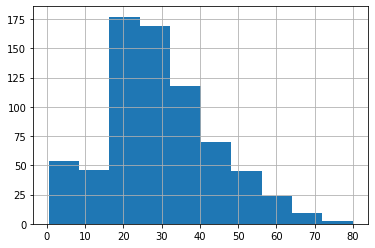

In [241]:
table['Age'].hist()
print('Histograma coluna Ages')

In [281]:
# Coluna Embarked
embarked_c = 0
for porto in table['Embarked']: 
    if porto == 'C':
        embarked_c += 1
        
embarked_s = 0
for porto in table['Embarked']: 
    if porto == 'S':
        embarked_s += 1
        
embarked_q = 0
for porto in table['Embarked']: 
    if porto == 'Q':
        embarked_q += 1

print(f'C: {embarked_c}, S: {embarked_s}, Q: {embarked_q}')

C: 168, S: 644, Q: 77


Analisando o histograma existe uma tendência para esquerda, logo acredito que o melhor variável para substituição seria a mediana, pois representa melhor a distribuição dos dados(mais para esquerda), apesar de o valor da média e mediana serem muito parecidos.

As idades de 70, 80 anos tem um efeito bem maior em descolar a média que as idades de de 0 a 10, por isso acho que a mediana seja a melhor medida para substituição.

E para a columa Embarked como são poucos valores *NaN* e somente 3 alternativas o melhor é substituir pela moda, no caso S.

Assim teremos a nova tabela:

In [291]:
# Preenchendo dados NaN
table['Age'].fillna(28, inplace = True)
table['Embarked'].fillna('S', inplace = True)
print('Nova tabela:')
table

Nova tabela:


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,28.0,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


### 3- Analisando os Dados

   Nessa fase temos de identificar padrões que nos ajude na predição dos sobreviventes.
   
   ![image](nazare-confusa.jpeg)
   
   Procurando correlações entre as variáveis:

In [232]:
round(table.corr(), 2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


Os resultados das correlações não foram animadores, o valor mais significativo foi uma correlação inversamente proporcional entre Pclass e Survived igual à -0,34 e a correlação de sobreviventes com o preço do bilhete indica o mesmo comportamento. Com isso podemos formular a primeira hipótese: quanto melhor a classe do passageiro mais chances ele terá de sobreviver?

In [353]:
# Tabela sobreviventes
table_survived = table[table['Survived'] == 1]
len_survived = len(table_survived)
print(f'Tabela sobreviventes: {len_survived}')
table_survived

Tabela sobreviventes: 342


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
8,9,1,3,female,27.0,0,2,11.1333,S
9,10,1,2,female,14.0,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
875,876,1,3,female,15.0,0,0,7.2250,C
879,880,1,1,female,56.0,0,1,83.1583,C
880,881,1,2,female,25.0,0,1,26.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S


In [358]:
# Percentual de sobreviventes por Pclas
class_1 = 0
class_2 = 0
class_3 = 0
for p_class in table_survived['Pclass']:
    if p_class == 1:
        class_1 += 1
    elif p_class == 2:
        class_2 += 1
    else:
        class_3 += 1
print(f'Classe 1: {class_1}, Classe 2: {class_2}, Classe 3: {class_3}')

Classe 1: 136, Classe 2: 87, Classe 3: 119


In [329]:
table['Pclass'].count()

891

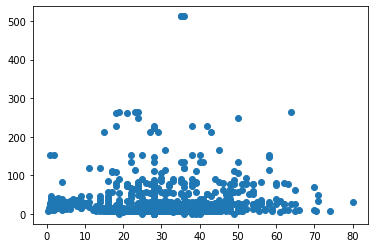

In [334]:
matplotlib.pyplot.plot(table['Age'], table['Fare'], 'o')
matplotlib.pyplot.show()

In [309]:
# Tabela Homens
male_table = table[table['Sex'] == 'male']
print('Tabela só com homens:')
male_table

Tabela só com homens:


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
4,5,0,3,male,35.0,0,0,8.0500,S
5,6,0,3,male,28.0,0,0,8.4583,Q
6,7,0,1,male,54.0,0,0,51.8625,S
7,8,0,3,male,2.0,3,1,21.0750,S
...,...,...,...,...,...,...,...,...,...
883,884,0,2,male,28.0,0,0,10.5000,S
884,885,0,3,male,25.0,0,0,7.0500,S
886,887,0,2,male,27.0,0,0,13.0000,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [338]:
# Correlação tabela homens
round(male_table.corr(), 2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,0.04,0.00,0.01,-0.08,-0.08,-0.01
Survived,0.04,1.00,-0.22,-0.10,-0.02,0.10,0.17
Pclass,0.00,-0.22,1.00,-0.36,0.08,-0.03,-0.47
Age,0.01,-0.10,-0.36,1.00,-0.26,-0.21,0.08
SibSp,-0.08,-0.02,0.08,-0.26,1.00,0.52,0.18
Parch,-0.08,0.10,-0.03,-0.21,0.52,1.00,0.31
Fare,-0.01,0.17,-0.47,0.08,0.18,0.31,1.00


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

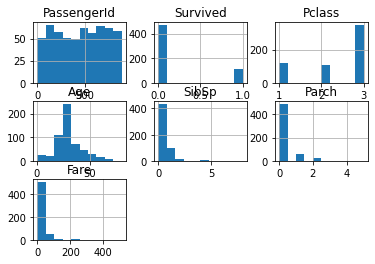

In [341]:
male_table.hist()

In [337]:
# Tabela Mulheres
female_table = table[table['Sex'] == 'female']
print('Tabela só com mulheres:')
female_table

Tabela só com mulheres:


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
8,9,1,3,female,27.0,0,2,11.1333,S
9,10,1,2,female,14.0,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
880,881,1,2,female,25.0,0,1,26.0000,S
882,883,0,3,female,22.0,0,0,10.5167,S
885,886,0,3,female,39.0,0,5,29.1250,Q
887,888,1,1,female,19.0,0,0,30.0000,S


In [339]:
# Correlação tabela mulheres
round(female_table.corr(), 2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.12,0.08,0.00,0.11,0.06
Survived,-0.01,1.00,-0.48,0.10,-0.26,-0.22,0.22
Pclass,-0.12,-0.48,1.00,-0.35,0.14,0.14,-0.63
Age,0.08,0.10,-0.35,1.00,-0.18,-0.11,0.17
SibSp,0.00,-0.26,0.14,-0.18,1.00,0.30,0.09
Parch,0.11,-0.22,0.14,-0.11,0.30,1.00,0.07
Fare,0.06,0.22,-0.63,0.17,0.09,0.07,1.00


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

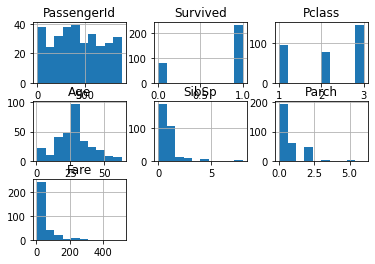

In [340]:
female_table.hist()

In [240]:
round(table['Age'].describe(), 2)

count    714.00
mean      29.70
std       14.53
min        0.42
25%       20.12
50%       28.00
75%       38.00
max       80.00
Name: Age, dtype: float64

In [297]:
table.groupby("Sex").count()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,,
female,314,314,314,314,314,314,314,314
male,577,577,577,577,577,577,577,577


### 4- Coclusão
   Definir plano de ação